# Bayesian Knowledge Tracing 
#### BKT for inferring human knowledge on a procedural task like programming

In [36]:
import numpy as np
import pandas as pd
import math
import itertools
from collections import defaultdict 
import copy
from pyBKT.generate import synthetic_data, random_model_uni
from pyBKT.fit import EM_fit
from copy import deepcopy
import matplotlib.pyplot as plt

## Parameter Estimation in BKT
Here we are learning the parameters of the BKT Model using EM algorithm and then comparing it with the empirically obtained parameter values

In [131]:
#parameters classes
num_gs = 1 #number of guess/slip classes
num_learns = 1 #number of learning rates

# State the prior probabilities
p_T = 0.30
p_F = 0.00
p_G = 0.10
p_S = 0.30
p_L0 = 0.15

# Learning sequences
training_data = {
's1' : [0,0,1,0,1,1],
's2' : [0,0,1,0,1,1],
's3' : [0,0,1,0,1,1],
's4' : [0,0,1,0,0,1],
's5' : [0,0,1,0,1,1],
's6' : [0,0,1,0,1,1],
's7' : [1,0,1,0,1,1],
's8' : [0,0,1,1,1,1],
's9' : [0,0,1,0,1,1],
's10' : [0,0,1,0,1,1],
's11' : [1,0,1,0,1,1],
's12' : [0,1,1,0,1,1],
's13' : [0,0,1,0,1,0],
's14' : [0,0,1,0,1,1],
's15' : [0,0,1,0,1,1],
's16' : [0,1,1,0,1,0],
's17' : [0,0,1,0,1,1],
's18' : [0,0,1,1,1,1],
's19' : [1,0,1,0,1,1],
's20' : [0,0,1,0,1,0],
's21' : [0,0,1,1,1,1],
's22' : [1,0,1,0,1,1],
's23' : [0,0,1,0,1,1],
's24' : [1,0,1,1,1,1],
}

# Test data per student
test_data = {
's1' : 10,
's2' : 12,
's3' : 8,
's4' : 6,
's5' : 18,
's6' : 25,
's7' : 19,
's8' : 25,
's9' : 28,
's10' : 9,
's11' : 14,
's12' : 12,
's13' : 11,
's14' : 13.5,
's15' : 18,
's16' : 27,
's17' : 28.5,
's18' : 21,
's19' : 18,
's20' : 13,
's21' : 18,
's22' : 19,
's23' : 21,
's24' : 22,
}


In [132]:
# Data conversion for parmater learning in BKT
lst = sum(list(training_data.values()), [])
lst_ = []
for i in lst:
    if i == 0:
        lst_.append(1)
    else:
        lst_.append(2)

In [6]:
#generate synthetic model and data.
truemodel = {}

truemodel["As"] =  np.zeros((num_learns,2,2), dtype=np.float_)
for i in range(num_learns):
    truemodel["As"][i] = np.transpose([[1-p_T, p_T], [p_F, 1-p_F]])

In [9]:
truemodel["learns"] = truemodel["As"][:,1, 0,]
truemodel["forgets"] = truemodel["As"][:,0, 1]

truemodel["pi_0"] = np.array([[1-p_L0], [p_L0]])
truemodel["prior"] = truemodel["pi_0"][1][0]

In [133]:
truemodel["guesses"] = np.full(num_gs, p_G, dtype=np.float_)
truemodel["slips"] = np.full(num_gs, p_S, dtype=np.float_)
#can optionally set learn class sequence - set randomly by synthetic_data if not included
#truemodel["resources"] = np.random.randint(1, high = num_resources, size = sum(observation_sequence_lengths))

#data!
print("generating data...")

#specifies 500 students with 100 observations for synthetic data
observation_sequence_lengths = np.full(500, 100, dtype=np.int) 
# data = synthetic_data.synthetic_data(truemodel, observation_sequence_lengths)
data = {
    'data':np.array(lst_).reshape((1,len(lst_))),
    'starts':np.array(list(range(1, 145, 6))),
    'lengths':np.array(len(list(range(1, 145, 6)))*[6]),
    'resources':np.array(len(lst_)*[1])    
}

generating data...


In [134]:
data

{'data': array([[1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1,
         1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1,
         2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2,
         1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1,
         2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1,
         2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
         1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2]]),
 'starts': array([  1,   7,  13,  19,  25,  31,  37,  43,  49,  55,  61,  67,  73,
         79,  85,  91,  97, 103, 109, 115, 121, 127, 133, 139]),
 'lengths': array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6]),
 'resources': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1,

In [120]:
#fit models, starting with random initializations
print('fitting! each dot is a new EM initialization')

num_fit_initializations = 5
best_likelihood = float("-inf")

for i in range(num_fit_initializations):
    # include this line to randomly set initial param values
	fitmodel = random_model_uni.random_model_uni(num_learns, num_gs) 
	(fitmodel, log_likelihoods) = EM_fit.EM_fit(fitmodel, data)
	if(log_likelihoods[-1] > best_likelihood):
		best_likelihood = log_likelihoods[-1]
		best_model = fitmodel

fitting! each dot is a new EM initialization


In [121]:
# compare the fit model to the true model

print('')
print('\ttruth\tlearned')
print('prior\t%.4f\t%.4f' % (truemodel['prior'], best_model["pi_0"][1][0]))
for r in range(num_learns):
    print('learn%d\t%.4f\t%.4f' % (r+1, truemodel['As'][r, 1, 0].squeeze(), best_model['As'][r, 1, 0].squeeze()))
for r in range(num_learns):
    print('forget%d\t%.4f\t%.4f' % (r+1, truemodel['As'][r, 0, 1].squeeze(), best_model['As'][r, 0, 1].squeeze()))

for s in range(num_gs):
    print('guess%d\t%.4f\t%.4f' % (s+1, truemodel['guesses'][s], best_model['guesses'][s]))
for s in range(num_gs):
    print('slip%d\t%.4f\t%.4f' % (s+1, truemodel['slips'][s], best_model['slips'][s]))


	truth	learned
prior	0.1000	0.0018
learn1	0.3000	0.5774
forget1	0.0000	0.0000
guess1	0.3000	0.1977
slip1	0.1000	0.3096


## Here we are doing Inference using the priors obtained empirically 

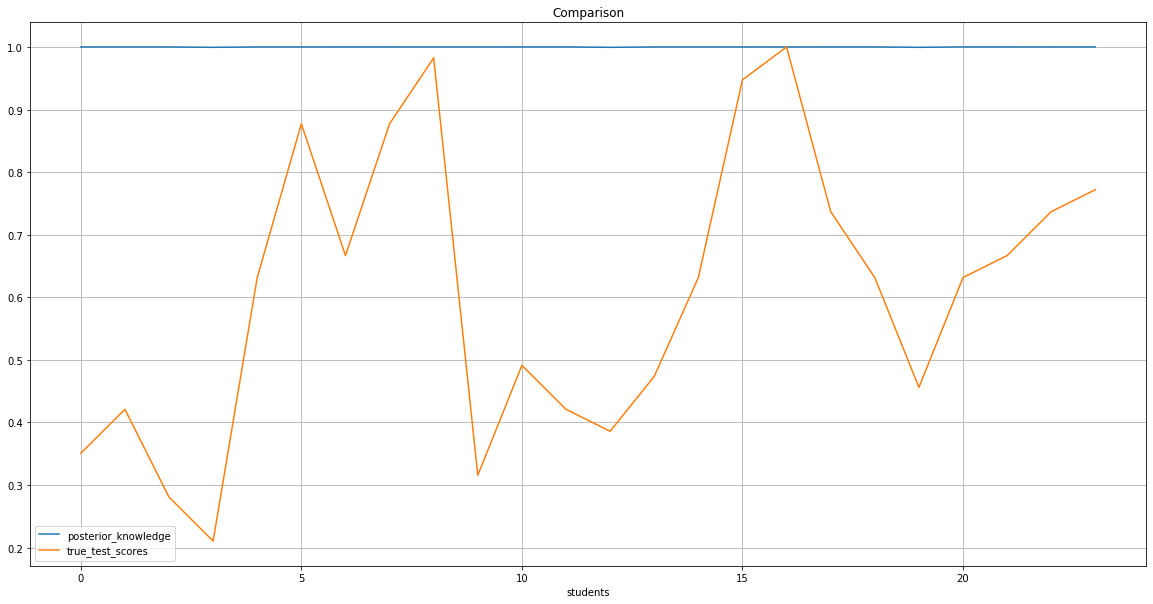

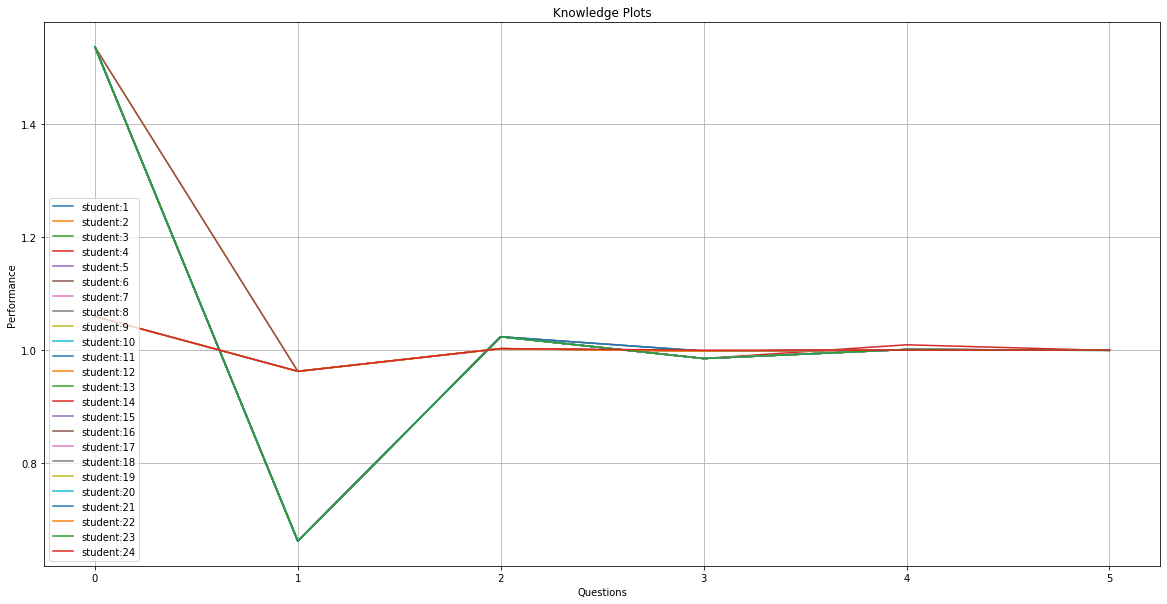

In [135]:
# Inference using BKT
# https://dl.acm.org/doi/pdf/10.1145/1595496.1562972
# Prior probabilities


class BKT_Inference:
    def __init__(self, p_T, p_F, p_G, p_S, p_L0, data, test_data):
        self.p_T = p_T
        self.p_F = p_F
        self.p_G = p_G
        self.p_S = p_S
        self.p_L0 = p_L0
        self.copy_p_L0 = p_L0
        self.learning_data = data
        self.test_data = test_data
        self.learn_step = {}


    def update_knowledge(self, response):
        if response == 0:
            p_L = (self.p_L0 * self.p_S) / (self.p_L0 * self.p_S) + ((1 - self.p_L0)*(1 - self.p_G))
        else:
            p_L = (self.p_L0 * (1 - self.p_S)) / (self.p_L0 * (1 - self.p_S)) + ((1 - self.p_L0)*self.p_G)
        return p_L


    def transition(self, prior):
        posterior = prior + (1-prior)*self.p_T
        return posterior


    def inference(self):
        learning = {}
        for student, questions in self.learning_data.items():
            temp = []
            for question in questions:
                #update the knowledge
                prior = self.update_knowledge(question)
                # update the posterior
                posterior = self.transition(prior)
                self.p_L0 = posterior
                temp.append(posterior)
            # update the learning posterior at the end of the sequence
            learning.update({student:posterior})
            # store learning at each step
            self.learn_step.update({student:temp})
            # reinitialize the knowledge prior for a new student
            self.p_L0 = self.copy_p_L0
        return learning
    
    
    def comparison(self):
        learning_scores = list(self.inference().values())
        test_scores = list(self.test_data.values())
        test_scores = [l/max(test_scores) for l in test_scores]
        # plot those two scores
        plt.figure(figsize=(20,10))
        plt.plot(range(0,len(learning_scores)), learning_scores, label="posterior_knowledge")
        plt.plot(range(0,len(test_scores)), test_scores, label="true_test_scores")
        plt.grid()
        plt.title("Comparison")
        plt.xlabel("students")
        plt.legend()
        plt.show()
    
    def knowledge_plot(self):
        i = 1
        plt.figure(figsize=(20,10))
        for k,v in self.learn_step.items():
            plt.plot(range(0, len(v)), v, label="student:"+str(i))
            i+= 1
        plt.grid()
        plt.title("Knowledge Plots")
        plt.xlabel("Questions")
        plt.ylabel("Performance")
        plt.legend()
        plt.show()


        
# Instantiate the BKT class
bkt_class = BKT_Inference(p_T, p_F, p_G, p_S, p_L0, training_data, test_data)
# Calculating the learning for each student
posterior = bkt_class.inference()
# Plot the comparison
bkt_class.comparison()
# Plot the knowledge plots
bkt_class.knowledge_plot()


In [55]:
posterior

{'s1': 0.99999561167515,
 's2': 0.99999561167515,
 's3': 0.99999561167515,
 's4': 0.99998976057535,
 's5': 0.99999561167515,
 's6': 0.99999561167515,
 's7': 0.99999811928935,
 's8': 0.99999811928935,
 's9': 0.99999561167515,
 's10': 0.99999561167515,
 's11': 0.99999811928935,
 's12': 0.99999811928935,
 's13': 0.99998976057535,
 's14': 0.99999561167515,
 's15': 0.99999561167515,
 's16': 0.99999561167515,
 's17': 0.99999561167515,
 's18': 0.99999811928935,
 's19': 0.99999811928935,
 's20': 0.99998976057535,
 's21': 0.99999811928935,
 's22': 0.99999811928935,
 's23': 0.99999561167515,
 's24': 0.99999919398115}